# Выявление невыгодных источников трафика


**Необходимо выявить невыгодные источники трафика, это позволит маркетологам снизить расходы и перераспределить бюджет.**


Рассмотрены 3 датасета: визиты (лог сервера с данными о посещениях сайта), информация о заказах, информация о расходах на маркетинг и отображены на графиках изменения каждой метрики во времени.

***В проекте рассчитаны метрики трёх видов:*** продуктовые метрики (DAU, WAU, MAU, рассчитан Retention Rate применяя когортный анализ), метрики электронной коммерции (сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки, среднее количество покупок на одного покупателя за 6 месяцев, средний чек, средний LTV по когортам за 6 месяцев), маркетинговые метрики (общая сумма расходов на маркетинг, как траты распределены по источникам, визуализированы изменения метрик во времени, средний CAC на одного покупателя для всего проекта и для каждого источника трафика, ROMI по когортам в разрезе источников, сравнение окупаемости за одинаковые периоды жизни когорт, построены графики, отражающие изменения метрик во времени).

**Результат исследования:** проанализировано как клиенты пользуются сервисом, когда делают первые покупки на сайте, сколько денег приносит компании каждый клиент, когда расходы на привлечение клиента окупаются, определены источники трафика, на которые маркетологам стоит делать упор, подведены итоги когортного анализа, определены самые перспективные для компании когорты клиентов.



## Изучение данных из файла

### Визиты

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

visit= pd.read_csv('/datasets/visits_log.csv')


visit.info()
display(visit.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [2]:
visit['Device'].value_counts()

desktop    262567
touch       96833
Name: Device, dtype: int64

<div class="alert alert-info">
<b> </b>  
В таблице нет пропусков, у данных с датами надо изменить формат и удалить дубликаты, если есть.
    
Необходимо удалить строки с ошибкой, например, когда дата/время окончания сессии меньше начала.     

</div>

In [3]:
visit = visit.drop_duplicates().reset_index(drop=True)
visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
visit = visit.rename(columns=
                   {
                       'Device': 'device',
                       'End Ts': 'end_ts',
                       'Source Id': 'source_id',
                       'Start Ts': 'start_ts',
                       'Uid': 'uid',
                   }
                  )

In [5]:
visit['source_id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

<div class="alert alert-info">
<b> </b>  
6 и 7 источники практически не были задействованы.    

</div>

In [6]:
visit['end_ts'] = pd.to_datetime(visit['end_ts'], format='%Y-%m-%d %H:%M:%S')
visit['start_ts'] = pd.to_datetime(visit['start_ts'], format='%Y-%m-%d %H:%M:%S')
visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [7]:
visit=visit[visit['end_ts']>visit['start_ts']]
visit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323604 entries, 0 to 359399
Data columns (total 5 columns):
device       323604 non-null object
end_ts       323604 non-null datetime64[ns]
source_id    323604 non-null int64
start_ts     323604 non-null datetime64[ns]
uid          323604 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 14.8+ MB


### Заказы

In [8]:
orders= pd.read_csv('/datasets/orders_log.csv')

orders.info()
display(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<div class="alert alert-info">
<b> </b>  
Пропущенных значений в таблице нет.
    
Поменяем столбец с временем покупки на формат даты и удалим дубликаты, если есть.

</div>

In [9]:
orders = orders.drop_duplicates().reset_index(drop=True)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [10]:
orders = orders.rename(columns=
                   {
                       'Buy Ts': 'buy_ts',
                       'Revenue': 'revenue',
                       'Uid': 'uid',
                   }
                  )

In [11]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [12]:
orders['buy_ts'].describe() 

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

In [13]:
orders=orders.query('buy_ts != "2018-06-01 00:02:00"')
orders['buy_ts'].describe() 


count                   50414
unique                  45990
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-05-31 23:56:00
Name: buy_ts, dtype: object

### Расходы

In [14]:
costs= pd.read_csv('/datasets/costs.csv')
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [15]:
costs = costs.drop_duplicates().reset_index(drop=True)
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [16]:
costs = costs.rename(columns=
                   {
                       'dt': 'costs_ts',
                   }
                  )

In [17]:
costs['costs_ts'] = pd.to_datetime(costs['costs_ts'], format='%Y-%m-%d')
#Выделим месяцы из дат в таблицах с расходами
costs['month'] = costs['costs_ts'].astype('datetime64[M]') 
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
source_id    2542 non-null int64
costs_ts     2542 non-null datetime64[ns]
costs        2542 non-null float64
month        2542 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 79.6 KB


,source_id,costs_ts,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [18]:
costs['costs_ts'].describe() 

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: costs_ts, dtype: object

In [19]:
costs['source_id'].value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

In [20]:
visit=visit.query('source_id != 6')
visit=visit.query('source_id != 7')
visit['source_id'].value_counts()

4     90896
3     76584
5     59520
2     43468
1     32146
9     11979
10     8971
Name: source_id, dtype: int64

<div class="alert alert-info">
<b> </b>  
Пропусков и дубликатов в данных не было.
    
В данных с визитами удалили строки с ошибкой, когда дата/время окончания сессии меньше начала. 
    
Так как среди оплаченных источников нет 6 и 7, убрали визиты с этих источников.
    
Столбцы с датами/временем перевели в формат дат.

</div>

## Продуктовые метрики

### DAU, WAU, MAU

In [21]:
#visit['start_year']  = visit['start_ts'].dt.year
visit['start_month'] = visit['start_ts'].dt.month
visit['start_week'] = visit['start_ts'].dt.week
visit['start_date'] = visit['start_ts'].dt.date
visit['start_date']=pd.to_datetime(visit['start_date'])

display(visit.head())
visit.info()

,device,end_ts,source_id,start_ts,uid,start_month,start_week,start_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2,8,2018-02-19
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,5,20,2018-05-20
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,9,35,2017-09-03
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,1,5,2018-01-30


<class 'pandas.core.frame.DataFrame'>
Int64Index: 323564 entries, 0 to 359399
Data columns (total 8 columns):
device         323564 non-null object
end_ts         323564 non-null datetime64[ns]
source_id      323564 non-null int64
start_ts       323564 non-null datetime64[ns]
uid            323564 non-null uint64
start_month    323564 non-null int64
start_week     323564 non-null int64
start_date     323564 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(3), object(1), uint64(1)
memory usage: 22.2+ MB


In [22]:
dau_total  = visit.groupby('start_date').agg({'uid': 'nunique'}).mean()
int(dau_total)

817

<div class="alert alert-info">
<b> </b>  
Количество уникальных пользователей в день - 817 человек.
</div>

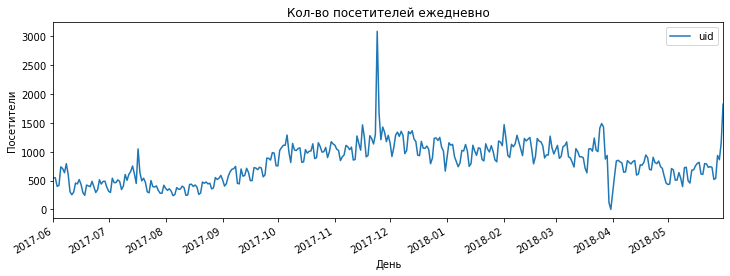

In [23]:
visit.groupby('start_date').agg({'uid': 'nunique'}).plot(kind='line', figsize=(12,4)).set_title('Кол-во посетителей ежедневно')
plt.xlabel("День") 
plt.ylabel("Посетители");

In [24]:
visit_dau = visit.groupby('start_date').agg({'uid': 'nunique'})
print(visit_dau[visit_dau['uid']>1200])
print(visit_dau[visit_dau['uid']>3000])
print(visit_dau[visit_dau['uid']>2000])
visit_dau[visit_dau['uid']<300]

             uid
start_date      
2017-10-06  1290
2017-11-13  1274
2017-11-16  1466
2017-11-17  1258
2017-11-20  1279
2017-11-21  1229
2017-11-23  1299
2017-11-24  3090
2017-11-25  1670
2017-11-26  1208
2017-11-27  1429
2017-11-28  1338
2017-11-30  1285
2017-12-04  1286
2017-12-05  1340
2017-12-06  1267
2017-12-07  1354
2017-12-08  1287
2017-12-11  1350
2017-12-12  1312
2017-12-13  1365
2017-12-14  1222
2017-12-25  1233
2017-12-26  1240
2017-12-28  1249
2018-02-01  1470
2018-02-02  1224
2018-02-08  1286
2018-02-12  1231
2018-02-14  1220
2018-02-15  1248
2018-02-19  1231
2018-02-26  1271
2018-03-22  1237
2018-03-25  1411
2018-03-26  1489
2018-03-27  1431
2018-05-31  1825
             uid
start_date      
2017-11-24  3090
             uid
start_date      
2017-11-24  3090


,uid
start_date,
2017-06-11,254
2017-06-17,292
2017-06-18,244
2017-06-24,293
2017-07-02,293
2017-07-23,288
2017-07-29,280
2017-07-30,279
2017-08-05,238


<div class="alert alert-info">
<b> </b>  
Количество посетителей значительно возрастает 24 ноября, 3090 посетителя за этот день.
Это может быть связано с днем матери, который 25 ноября.
    
А также есть рост посещений 31 мая, 1825 посетителей за этот день.
Это может быть связано с днем ребенка, который 1 июня.    
    
Если обобщить до месяцев, бОльшая посещаемость в ноябре- декабре и немного меньше февраль-март
    
Самая низкая посещаемость 30 и 31 марта, и в целом в летние месяцы.
</div>

In [25]:
visit.groupby('start_date').agg({'uid': 'nunique'})['uid'].reset_index().sort_values(by = 'uid', ascending = False).head(10)

,start_date,uid
176,2017-11-24,3090
363,2018-05-31,1825
177,2017-11-25,1670
298,2018-03-26,1489
245,2018-02-01,1470
168,2017-11-16,1466
299,2018-03-27,1431
179,2017-11-27,1429
297,2018-03-25,1411
195,2017-12-13,1365


In [26]:
wau_total  = visit.groupby('start_week').agg({'uid': 'nunique'}).mean()
int(wau_total)

5245

<div class="alert alert-info">
<b> </b>  
Количество уникальных пользователей в неделю - 5245 человек.
</div>

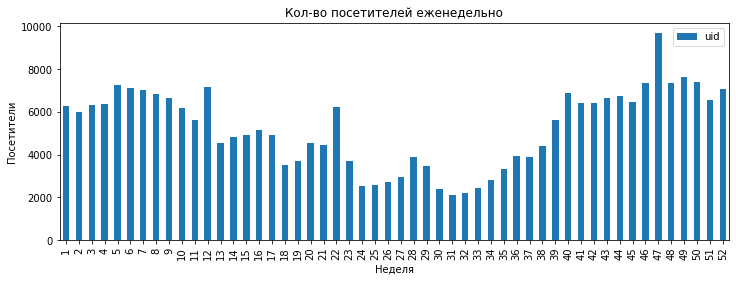

In [27]:
visit.groupby('start_week').agg({'uid': 'nunique'}).plot(kind='bar', figsize=(12,4)).set_title('Кол-во посетителей еженедельно')
plt.xlabel("Неделя") 
plt.ylabel("Посетители"); 

<div class="alert alert-info">
<b> </b>  
Недельный график посещаемости подтверждает информацию о том, что в середине года, т.е. в летние месяцы значительно меньше заходов.
Конец года (последние 13 недель) и начало года - самые посещаемые.
</div>

In [28]:
mau_total = visit.groupby('start_month').agg({'uid': 'nunique'}).mean()
int(mau_total)

20952

<div class="alert alert-info">
<b> </b>  
Количество уникальных пользователей в месяц - 20952 человека.
</div>

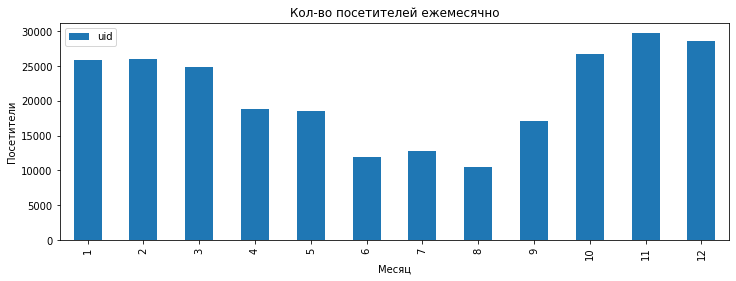

In [29]:
visit.groupby('start_month').agg({'uid': 'nunique'}).plot(kind='bar', figsize=(12,4)).set_title('Кол-во посетителей ежемесячно')
plt.xlabel("Месяц") 
plt.ylabel("Посетители"); 


<div class="alert alert-info">
<b> </b>  
Месячный график наглядно выделяет период с сентября по март включительно, в эти месяцы сервис Афиша наиболее востребован.

</div>

### Сколько каждый пользователь в среднем заходит на сайт

In [30]:
visit.groupby('uid').agg({'start_ts': 'count'}).mean()

start_ts    1.562945
dtype: float64

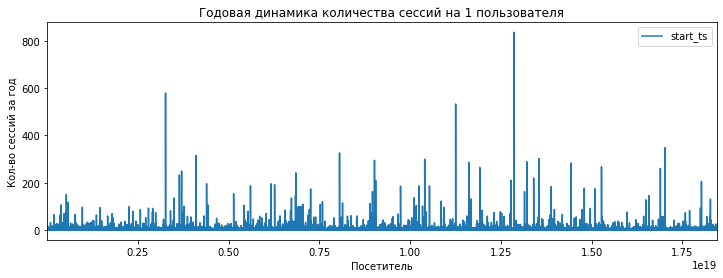

In [31]:
visit.groupby('uid').agg({'start_ts': 'count'}).plot(style = '-', figsize=(12,4)).set_title(
    'Годовая динамика количества сессий на 1 пользователя'
)
plt.xlabel("Посетитель") 
plt.ylabel("Кол-во сессий за год"); 

In [32]:
visit_year_uid=visit.groupby('uid').agg({'start_ts': 'count'}).reset_index()

visit_year_uid.sort_values(by = 'start_ts', ascending = False).head(15)

,uid,start_ts
144592,12869801667763685675,836
36642,3263486045884611639,579
126584,11255648391090536411,533
191357,17030528792926543083,349
90690,8056418121947262981,326
46078,4103526784471735383,315
152191,13551952738594011920,302
116917,10403169074343195591,300
101367,9019681082555518724,295
148522,13216107653026783144,289


In [33]:
visit_year_uid['start_ts'].value_counts().head(10)

1     160474
2      27915
3       9023
4       3890
5       1940
6       1088
7        686
8        423
9        310
10       200
Name: start_ts, dtype: int64

In [34]:
visit_year_uid.shape[0]

207022

In [35]:
visit_year_uid.query('start_ts>200').shape[0]

22

In [36]:
visit_year_uid.query('10<start_ts<=200').shape[0]

1051

In [37]:
visit_year_uid.query('start_ts<=10').shape[0]

205949

<div class="alert alert-info">
<b> % повторного пользования сервисом за год небольшой  </b>  
    
99,48% посетителей заходят на сайт не более 10 раз за год.
    
77.50% - 1 раз за год.  
    
13.50% - 2 раз за год.      
    
0,5% пользователей зашли от 10 до 200 раз за год.
    
У 22 человек из 201 022 пользователей кол-во сессий за год больше 200.

</div>

### Сколько времени пользователи на сайте

In [38]:
visit['long_dt']=visit['end_ts']-visit['start_ts']
display(visit['long_dt'].describe())
visit['long_dt'].mean()

count                    323564
mean     0 days 00:11:54.164900
std      0 days 00:17:06.321529
min             0 days 00:00:19
25%             0 days 00:02:00
50%             0 days 00:06:00
75%             0 days 00:15:00
max             0 days 11:51:00
Name: long_dt, dtype: object

Timedelta('0 days 00:11:54.164900')

<div class="alert alert-info">
<b> В среднем пользователи проводят около 11 минут на сайте</b>   
    
Половина пользователей - до 6 минут.
    
75% пользовотелей - до 15 минут.    
</div>

### Retention Rate

<div class="alert alert-info">
<b></b>
Определим событие и период — на их основе сформируем когорту. Возьмём дату, когда пользователь впервые проявил активность на сайте.
   
</div>

In [39]:
visit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323564 entries, 0 to 359399
Data columns (total 9 columns):
device         323564 non-null object
end_ts         323564 non-null datetime64[ns]
source_id      323564 non-null int64
start_ts       323564 non-null datetime64[ns]
uid            323564 non-null uint64
start_month    323564 non-null int64
start_week     323564 non-null int64
start_date     323564 non-null datetime64[ns]
long_dt        323564 non-null timedelta64[ns]
dtypes: datetime64[ns](3), int64(3), object(1), timedelta64[ns](1), uint64(1)
memory usage: 24.7+ MB


In [40]:
#найдем дату первого визита для каждого пользователя
first_activity_date = visit.groupby(['uid'])['start_date'].min()
first_activity_date.name = 'first_activity_date'
visit = visit.join(first_activity_date,on='uid') 
visit.head()
visit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323564 entries, 0 to 359399
Data columns (total 10 columns):
device                 323564 non-null object
end_ts                 323564 non-null datetime64[ns]
source_id              323564 non-null int64
start_ts               323564 non-null datetime64[ns]
uid                    323564 non-null uint64
start_month            323564 non-null int64
start_week             323564 non-null int64
start_date             323564 non-null datetime64[ns]
long_dt                323564 non-null timedelta64[ns]
first_activity_date    323564 non-null datetime64[ns]
dtypes: datetime64[ns](4), int64(3), object(1), timedelta64[ns](1), uint64(1)
memory usage: 27.2+ MB


<div class="alert alert-info">
<b></b>

Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты
   
</div>

In [41]:
visit['start_date_month'] = visit['start_date'].astype('datetime64[M]')
visit['first_date_month'] = visit['first_activity_date'].astype('datetime64[M]')

In [42]:
visit['cohort_lifetime'] = ((
    visit['start_date_month']
    - visit['first_date_month']
) / np.timedelta64(1, 'M')).round().astype('int')

visit['cohort_lifetime'].value_counts()

0     242516
1      20816
2      13143
3      10623
4       8760
5       7414
6       6003
7       4624
8       3565
9       2719
10      1939
11      1442
Name: cohort_lifetime, dtype: int64

<div class="alert alert-info">
<b></b>

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»
   
</div>



In [43]:
cohorts = visit.groupby(['first_date_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_date_month,cohort_lifetime,uid
0,2017-06-01,0,11883
1,2017-06-01,1,900
2,2017-06-01,2,605
3,2017-06-01,3,710
4,2017-06-01,4,777
...,...,...,...
73,2018-03-01,1,766
74,2018-03-01,2,480
75,2018-04-01,0,14214
76,2018-04-01,1,675


<div class="alert alert-info">
<b></b>

Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждый следующий месяц.
Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц
</div>

In [44]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_date_month', 'uid']
]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_uid'}) 
initial_users_count


,first_date_month,cohort_uid
0,2017-06-01,11883
12,2017-07-01,11822
23,2017-08-01,9213
33,2017-09-01,15123
42,2017-10-01,23534
50,2017-11-01,24851
57,2017-12-01,23021
63,2018-01-01,20570
68,2018-02-01,20173
72,2018-03-01,18792


<div class="alert alert-info">
<b></b>

Объединим данные по когортам с исходным количеством пользователей в когорте
</div>

In [45]:
cohorts = cohorts.merge(initial_users_count,on='first_date_month') 
cohorts.head()

,first_date_month,cohort_lifetime,uid,cohort_uid
0,2017-06-01,0,11883,11883
1,2017-06-01,1,900,11883
2,2017-06-01,2,605,11883
3,2017-06-01,3,710,11883
4,2017-06-01,4,777,11883


<div class="alert alert-info">
<b></b>

Рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте
</div>

In [46]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_uid'] 

<div class="alert alert-info">
<b></b>

Построим сводную таблицу и создадим тепловую карту
</div>

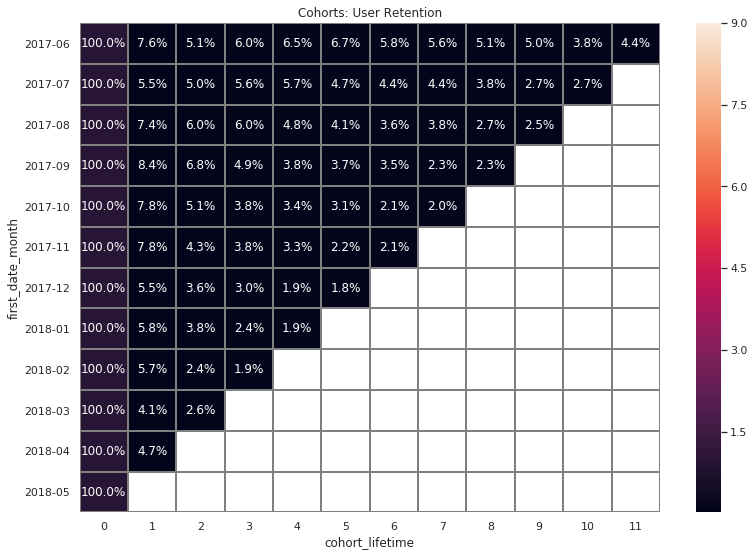

In [47]:
cohorts['first_date_month']=cohorts['first_date_month'].dt.strftime('%Y-%m')

retention_pivot = cohorts.pivot_table(
    index='first_date_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)


sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=9); 


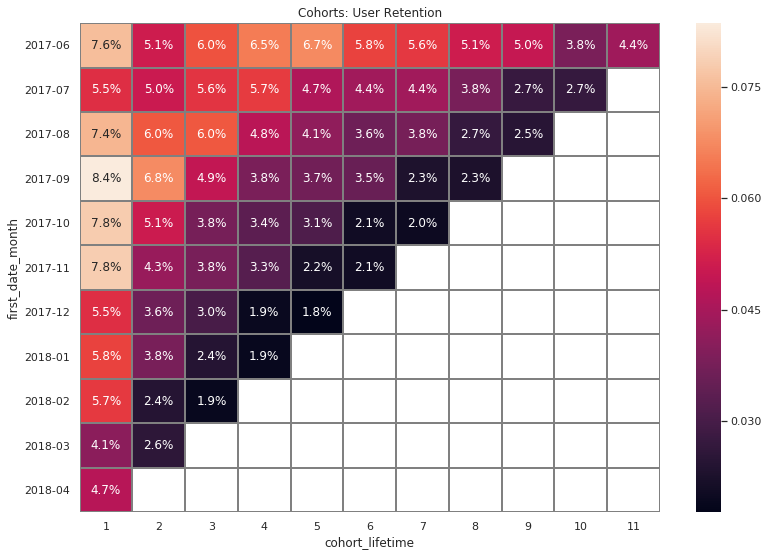

In [48]:
retention_pivot_2 = cohorts.loc[cohorts['cohort_lifetime']>0].pivot_table(
    index='first_date_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)


sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot_2, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 


In [49]:
retention_pivot.fillna('') 

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_date_month,,,,,,,,,,,,
2017-06,1.0,0.0757384,0.0509131,0.0597492,0.0653875,0.0674914,0.0577295,0.0561306,0.0509972,0.0497349,0.0381217,0.0439283
2017-07,1.0,0.0545593,0.0504145,0.0556589,0.056674,0.0465234,0.0440704,0.0440704,0.0378954,0.0273219,0.0270682,
2017-08,1.0,0.0743515,0.060458,0.060458,0.0479757,0.0414631,0.0362531,0.0376642,0.0271356,0.0247476,,
2017-09,1.0,0.0835813,0.0677776,0.0493288,0.0380877,0.0369636,0.0353766,0.0228791,0.0227468,,,
2017-10,1.0,0.0781423,0.0508201,0.0377751,0.0336534,0.0311889,0.0207784,0.0198011,,,,
2017-11,1.0,0.078186,0.0427347,0.0378254,0.0325943,0.0217295,0.0206028,,,,,
2017-12,1.0,0.0546892,0.0364884,0.0301898,0.0194605,0.0177229,,,,,,
2018-01,1.0,0.0578026,0.0378221,0.0243559,0.0192513,,,,,,,
2018-02,1.0,0.0565607,0.0242899,0.0191841,,,,,,,,


<div class="alert alert-info">
<b>Средний Retention Rate на второй месяц "жизни" когорт</b>


</div>

In [50]:
(retention_pivot[1].mean())*100


6.380561330947556

<div class="alert alert-info">
<b>Только 6,5% пользователей в среднем относительно их изначального числа вернулось во второй месяц</b>

</div>

<div class="alert alert-info">
<b>Максимальный Retention Rate 8,4%</b>
Retention Rate по всем когортам снижается.
Привлечённые пользователи пользуется сервисов повторно неохотно, что не очень хорошо для потенциальной выручки.    
</div>

## Метрики электронной коммерции

### Время от первого посещения до первой покупки

In [51]:
print(visit.info())
visit.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323564 entries, 0 to 359399
Data columns (total 13 columns):
device                 323564 non-null object
end_ts                 323564 non-null datetime64[ns]
source_id              323564 non-null int64
start_ts               323564 non-null datetime64[ns]
uid                    323564 non-null uint64
start_month            323564 non-null int64
start_week             323564 non-null int64
start_date             323564 non-null datetime64[ns]
long_dt                323564 non-null timedelta64[ns]
first_activity_date    323564 non-null datetime64[ns]
start_date_month       323564 non-null datetime64[ns]
first_date_month       323564 non-null datetime64[ns]
cohort_lifetime        323564 non-null int64
dtypes: datetime64[ns](6), int64(4), object(1), timedelta64[ns](1), uint64(1)
memory usage: 34.6+ MB
None


,device,end_ts,source_id,start_ts,uid,start_month,start_week,start_date,long_dt,first_activity_date,start_date_month,first_date_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,12,51,2017-12-20,00:18:00,2017-12-20,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2,8,2018-02-19,00:28:00,2018-02-19,2018-02-01,2018-02-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,5,20,2018-05-20,00:24:00,2018-03-09,2018-05-01,2018-03-01,2
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,9,35,2017-09-03,00:01:00,2017-09-03,2017-09-01,2017-09-01,0
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,1,5,2018-01-30,00:56:00,2017-06-29,2018-01-01,2017-06-01,7


In [52]:
first_start_visit  = visit.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_start_visit = first_start_visit.rename(columns=
                   {
                       'start_ts': 'first_start_visit',
                   }
                  )
print(first_start_visit.info())
first_start_visit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207022 entries, 0 to 207021
Data columns (total 2 columns):
uid                  207022 non-null uint64
first_start_visit    207022 non-null datetime64[ns]
dtypes: datetime64[ns](1), uint64(1)
memory usage: 3.2 MB
None


,uid,first_start_visit
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [53]:
print(orders.info())
orders.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50414 entries, 0 to 50413
Data columns (total 3 columns):
buy_ts     50414 non-null datetime64[ns]
revenue    50414 non-null float64
uid        50414 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.5 MB
None


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [54]:
first_start_order  = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_start_order = first_start_order.rename(columns=
                   {
                       'buy_ts': 'first_start_order',
                   }
                  )

orders = orders.merge(first_start_order,on='uid', how='left') 
print(orders.info())
orders.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50414 entries, 0 to 50413
Data columns (total 4 columns):
buy_ts               50414 non-null datetime64[ns]
revenue              50414 non-null float64
uid                  50414 non-null uint64
first_start_order    50414 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), uint64(1)
memory usage: 1.9 MB
None


,buy_ts,revenue,uid,first_start_order
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


In [55]:
orders = orders.merge(first_start_visit,on='uid', how='left') 
display(orders.head())
orders.info()

,buy_ts,revenue,uid,first_start_order,first_start_visit
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50414 entries, 0 to 50413
Data columns (total 5 columns):
buy_ts               50414 non-null datetime64[ns]
revenue              50414 non-null float64
uid                  50414 non-null uint64
first_start_order    50414 non-null datetime64[ns]
first_start_visit    49939 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(1), uint64(1)
memory usage: 2.3 MB


In [56]:
orders['visit_order_max']=orders['first_start_order']-orders['first_start_visit']
orders=orders.query('first_start_order > first_start_visit')
display(orders.head())
orders.info()

,buy_ts,revenue,uid,first_start_order,first_start_visit,visit_order_max
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,00:01:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,00:11:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,00:02:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,00:15:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,00:27:00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45612 entries, 0 to 50413
Data columns (total 6 columns):
buy_ts               45612 non-null datetime64[ns]
revenue              45612 non-null float64
uid                  45612 non-null uint64
first_start_order    45612 non-null datetime64[ns]
first_start_visit    45612 non-null datetime64[ns]
visit_order_max      45612 non-null timedelta64[ns]
dtypes: datetime64[ns](3), float64(1), timedelta64[ns](1), uint64(1)
memory usage: 2.4 MB


In [57]:
orders['visit_order_max'].describe()

count                      45612
mean     18 days 00:16:58.410944
std      46 days 17:25:33.513614
min              0 days 00:01:00
25%              0 days 00:06:00
50%              0 days 00:28:00
75%              5 days 01:45:30
max            363 days 07:04:00
Name: visit_order_max, dtype: object

In [58]:
orders.query('visit_order_max> "23:59:59"')['visit_order_max'].describe()

count                      15022
mean     54 days 13:19:32.136865
std      68 days 02:30:22.720028
min              1 days 00:00:00
25%              5 days 04:34:00
50%             21 days 23:05:00
75%             85 days 13:18:45
max            363 days 07:04:00
Name: visit_order_max, dtype: object

In [59]:
orders.query('visit_order_max> "23:59:59"')['visit_order_max'].count()

15022

In [60]:
#orders['visit_order_max']=(orders['visit_order_max']/np.timedelta64(1,'m')).astype('int') 
#orders.head()

In [61]:
orders['visit_order_max']=(orders['visit_order_max']/np.timedelta64(1,'D')).astype('int')

In [62]:
orders['visit_order_max'].describe()

count    45612.000000
mean        17.809721
std         46.612575
min          0.000000
25%          0.000000
50%          0.000000
75%          5.000000
max        363.000000
Name: visit_order_max, dtype: float64

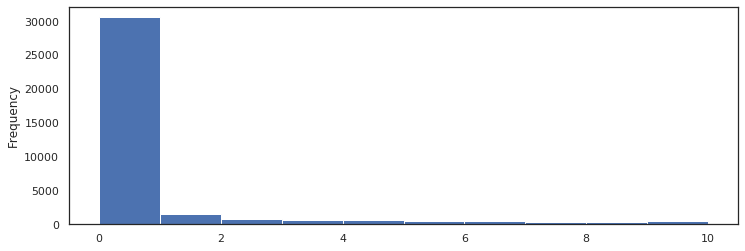

In [63]:
orders['visit_order_max'].plot(kind='hist', bins=10, range=(0, 10), figsize=(12,4))

<div class="alert alert-info">
<b>БОльшая часть покупателей делают свой первый заказ в день первого посещения сервиса "Яндекс Афиша"  </b> 
    

    
</div>

<div class="alert alert-info">
<b></b>

50% покупателей делают покупку в первые 28 минут нахождения на сайте.
    
25% покупателей делают покупку в первые 6 минут нахождения на сайте.
    
15022 посетителей делают покупки не ранее суток с момента первого посещения сайта,
от всех покупателей это составляет 33%.
    
    

</div>

### Среднее кол-во покупок на 1 покупателя за 6 месяцев

In [64]:
orders.head()

,buy_ts,revenue,uid,first_start_order,first_start_visit,visit_order_max
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,0


In [65]:
orders['buy_ts_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_order_month'] = orders['first_start_order'].astype('datetime64[M]')

orders['cohort_lifetime'] = ((
    orders['buy_ts_month']
    - orders['first_order_month']
) / np.timedelta64(1, 'M')).round().astype('int')

orders.head()

,buy_ts,revenue,uid,first_start_order,first_start_visit,visit_order_max,buy_ts_month,first_order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,0,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,0,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,0,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,0,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,0,2017-06-01,2017-06-01,0


In [66]:
cohorts_orders = orders.groupby(['first_order_month','cohort_lifetime']).agg({'uid':'nunique', 'buy_ts':'count'}).reset_index()
cohorts_orders = cohorts_orders.rename(columns=
                   {
                       'buy_ts': 'buy_count',
                       'uid': 'uid_nunique',
                   }
                  )
cohorts_orders['orders_per_user']=cohorts_orders['buy_count']/cohorts_orders['uid_nunique']
cohorts_orders

,first_order_month,cohort_lifetime,uid_nunique,buy_count,orders_per_user
0,2017-06-01,0,1803,2033,1.127565
1,2017-06-01,1,53,143,2.698113
2,2017-06-01,2,44,138,3.136364
3,2017-06-01,3,43,141,3.279070
4,2017-06-01,4,73,181,2.479452
...,...,...,...,...,...
73,2018-03-01,1,82,170,2.073171
74,2018-03-01,2,55,173,3.145455
75,2018-04-01,0,2111,2299,1.089057
76,2018-04-01,1,63,188,2.984127


In [67]:
cohorts_orders_pivot=cohorts_orders.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='orders_per_user',
    aggfunc='mean',
) 
cohorts_orders_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.127565,2.698113,3.136364,3.279070,2.479452,2.568966,3.452830,2.575000,2.653061,2.743590,1.769231,1.630435
2017-07-01,1.125874,1.957447,2.188679,1.655738,1.468085,2.194444,1.735294,1.228571,1.384615,1.095238,2.227273,NaN
2017-08-01,1.106688,1.877193,1.959184,1.900000,2.184211,2.000000,1.703704,1.850000,2.500000,1.500000,NaN,NaN
2017-09-01,1.127848,1.675000,1.609195,2.257143,1.291667,1.733333,1.677419,1.513514,1.435897,NaN,NaN,NaN
2017-10-01,1.129756,1.393617,1.348624,1.337349,1.382022,1.424242,1.576923,1.935484,NaN,NaN,NaN,NaN
2017-11-01,1.172622,1.805825,1.539823,2.040000,1.729730,1.239130,1.644068,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.145066,1.869565,2.076923,1.873563,1.733333,1.637931,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.110720,2.000000,2.000000,1.538462,1.785714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.116320,1.908257,1.462963,1.805556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
cohorts_orders_pivot.cumsum(axis=1)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.127565,3.825678,6.962042,10.241112,12.720564,15.289529,18.742360,21.317360,23.970421,26.714011,28.483241,30.113676
2017-07-01,1.125874,3.083321,5.272000,6.927738,8.395823,10.590267,12.325562,13.554133,14.938748,16.033986,18.261259,NaN
2017-08-01,1.106688,2.983881,4.943065,6.843065,9.027275,11.027275,12.730979,14.580979,17.080979,18.580979,NaN,NaN
2017-09-01,1.127848,2.802848,4.412044,6.669186,7.960853,9.694186,11.371606,12.885119,14.321017,NaN,NaN,NaN
2017-10-01,1.129756,2.523373,3.871996,5.209346,6.591368,8.015611,9.592534,11.528018,NaN,NaN,NaN,NaN
2017-11-01,1.172622,2.978447,4.518270,6.558270,8.288000,9.527131,11.171198,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.145066,3.014631,5.091555,6.965118,8.698451,10.336382,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.110720,3.110720,5.110720,6.649182,8.434896,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.116320,3.024577,4.487540,6.293096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
(cohorts_orders_pivot.cumsum(axis=1)[5]/36).sum()
#разделим на 36, т.к. 6 месяцев и 6 когорт рассматриваем, 
#таким образом найдем среднее кол-во покупок на 1 пользователя за 6 месяцев

2.068899493034032

<div class="alert alert-info">
<b>Среднее кол-во покупок на одного покупателя за 6 месяцев около 2</b>


</div>

### Средний чек

In [70]:
orders.head()

,buy_ts,revenue,uid,first_start_order,first_start_visit,visit_order_max,buy_ts_month,first_order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,0,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,0,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,0,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,0,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,0,2017-06-01,2017-06-01,0


In [71]:
average_check=orders.groupby(
    ['buy_ts_month']
).agg({'revenue': 'sum', 'uid': 'count'}).reset_index()
average_check['average_check']=average_check['revenue']/average_check['uid']
average_check

,buy_ts_month,revenue,uid,average_check
0,2017-06-01,8419.96,2033,4.141643
1,2017-07-01,11350.10,2075,5.469928
2,2017-08-01,7738.98,1620,4.777148
3,2017-09-01,16125.00,3037,5.309516
4,2017-10-01,25192.39,5063,4.975783
5,2017-11-01,24597.77,5159,4.767934
6,2017-12-01,34263.93,5687,6.024957
7,2018-01-01,17757.91,4298,4.131668
8,2018-02-01,23814.02,4819,4.941693
9,2018-03-01,26639.62,4790,5.561507


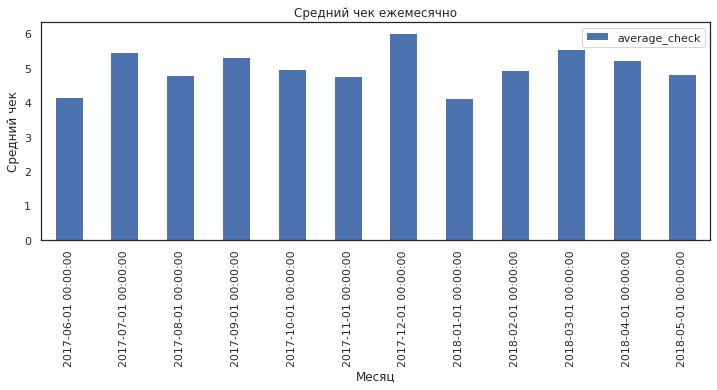

In [72]:
average_check.groupby(
    ['buy_ts_month']
).agg({'average_check': 'sum'}).plot(kind='bar', figsize=(12,4)).set_title('Средний чек ежемесячно') 
plt.xlabel('Месяц') 
plt.ylabel('Средний чек'); 
plt.show()

<div class="alert alert-info">
<b></b>
Самый маленький чек в январе 2018 года,
большой - декабрь 2017г.  

</div>

<div class="alert alert-info">
<b>Посмотрим средний чек по когортам</b>


</div>

In [73]:
orders_grouped_cohorts_revenue = orders.groupby(
    ['first_order_month', 'cohort_lifetime']
).agg({'revenue': 'sum', 'uid': 'count'}).reset_index()
orders_grouped_cohorts_revenue.head()
#nunique

,first_order_month,cohort_lifetime,revenue,uid
0,2017-06-01,0,8419.96,2033
1,2017-06-01,1,813.72,143
2,2017-06-01,2,752.12,138
3,2017-06-01,3,1399.98,141
4,2017-06-01,4,1357.19,181


In [74]:
orders_grouped_cohorts_revenue['revenue_per_user'] = (
    orders_grouped_cohorts_revenue['revenue']
    / orders_grouped_cohorts_revenue['uid']
) 
orders_grouped_cohorts_revenue.head()

,first_order_month,cohort_lifetime,revenue,uid,revenue_per_user
0,2017-06-01,0,8419.96,2033,4.141643
1,2017-06-01,1,813.72,143,5.690350
2,2017-06-01,2,752.12,138,5.450145
3,2017-06-01,3,1399.98,141,9.928936
4,2017-06-01,4,1357.19,181,7.498287


<div class="alert alert-info">
<b></b>
Оценим, как изменяется средний чек в зависимости от времени, прошедшего с момента первой покупки.


</div>


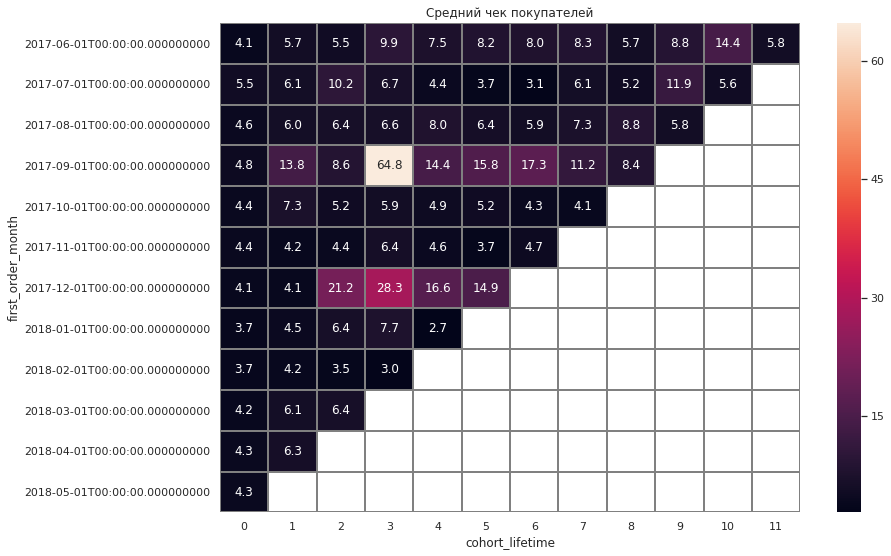

In [75]:
orders_grouped_cohorts_revenue_pivot=orders_grouped_cohorts_revenue.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='revenue_per_user',
    aggfunc='mean',
) 

plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(orders_grouped_cohorts_revenue_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray') 


<div class="alert alert-info">
<b> </b>

    
В июне, сентябре и декабре 2017 пришли самые платежеспособные покупатели.
    
Средний чек растет у каждой когорты, значит в целом покупатели становятся лояльнее к продукту.

</div>

In [76]:
average_check['average_check'].mean()

5.0117511043975576

<div class="alert alert-info">
<b> </b>

    
Средний чек по всем когортам за весь период - 5.

</div>

### LTV

<div class="alert alert-info">
<b> </b>
    LTV удобно считать по когортам. Для этого нужно:
    
1.	найти дату первой покупки каждого покупателя;
    
2.	вычислить число новых покупателей за каждую дату;
    
3.	добавить дату первой покупки в таблицу с заказами;
    
4.	сгруппировать таблицу и посчитать выручку.

</div>

In [77]:
costs.head()

,source_id,costs_ts,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [78]:
orders.head()

,buy_ts,revenue,uid,first_start_order,first_start_visit,visit_order_max,buy_ts_month,first_order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,0,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,0,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,0,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,0,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,0,2017-06-01,2017-06-01,0


In [79]:
#Посчитаем количество новых покупателей (n_buyers) за каждый месяц

cohort_sizes = (
    orders.groupby('first_order_month')
    .agg({'uid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']
print(cohort_sizes)


   first_order_month  n_buyers
0         2017-06-01      1803
1         2017-07-01      1716
2         2017-08-01      1256
3         2017-09-01      2370
4         2017-10-01      3969
5         2017-11-01      3806
6         2017-12-01      4074
7         2018-01-01      3125
8         2018-02-01      3370
9         2018-03-01      3209
10        2018-04-01      2111
11        2018-05-01      2757


In [80]:
#Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку

cohorts = (
    orders.groupby(['first_order_month', 'cohort_lifetime'])
    .agg({'revenue': 'sum'})
    .reset_index()
)

cohorts.head()

,first_order_month,cohort_lifetime,revenue
0,2017-06-01,0,8419.96
1,2017-06-01,1,813.72
2,2017-06-01,2,752.12
3,2017-06-01,3,1399.98
4,2017-06-01,4,1357.19


In [81]:
#С точки зрения когортного анализа LTV — накопительная выручка когорты в пересчёте на количество людей. 
#Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц

ltv = pd.merge(cohort_sizes, cohorts, on='first_order_month')
ltv.head()

,first_order_month,n_buyers,cohort_lifetime,revenue
0,2017-06-01,1803,0,8419.96
1,2017-06-01,1803,1,813.72
2,2017-06-01,1803,2,752.12
3,2017-06-01,1803,3,1399.98
4,2017-06-01,1803,4,1357.19


In [82]:
#LTV считают из валовой прибыли, а т.к маржинальность 100%, значит валовая прибыль равна выручке. 
#LTV — относительный показатель. Его удобнее смотреть по «возрастным» когортам.

ltv['ltv'] = ltv['revenue'] / ltv['n_buyers']
ltv.head()

,first_order_month,n_buyers,cohort_lifetime,revenue,ltv
0,2017-06-01,1803,0,8419.96,4.669972
1,2017-06-01,1803,1,813.72,0.451314
2,2017-06-01,1803,2,752.12,0.417149
3,2017-06-01,1803,3,1399.98,0.776473
4,2017-06-01,1803,4,1357.19,0.752740


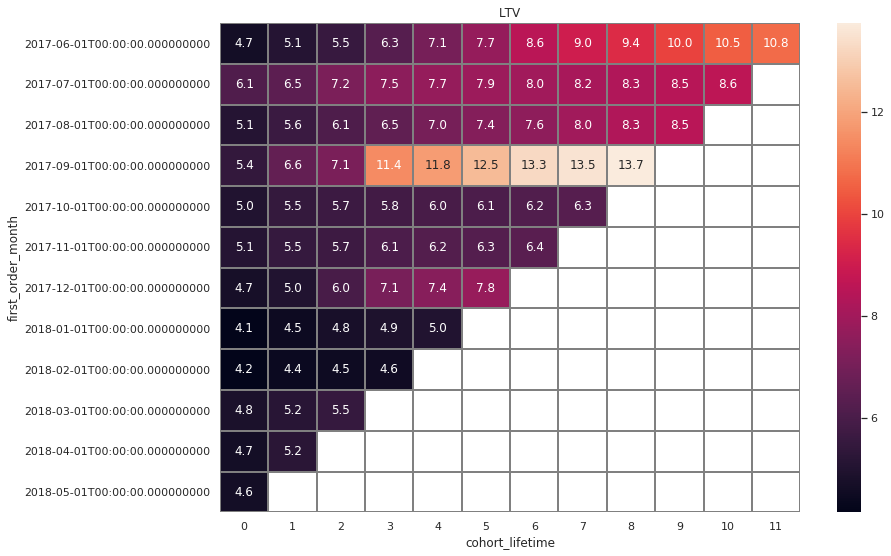

In [83]:
ltv_pivot = ltv.pivot_table(
    index='first_order_month', columns='cohort_lifetime', values='ltv', aggfunc='mean'
)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(ltv_pivot.cumsum(axis=1), annot=True, fmt='.1f', linewidths=1, linecolor='gray'); 

In [84]:
ltv_pivot=ltv_pivot.cumsum(axis=1)
ltv_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.669972,5.121287,5.538436,6.314908,7.067648,7.741314,8.552146,9.029052,9.440488,9.964221,10.514187,10.754803
2017-07-01,6.140082,6.464907,7.153240,7.548403,7.727296,7.896259,8.004149,8.157244,8.322086,8.481958,8.642949,NaN
2017-08-01,5.118997,5.631576,6.120772,6.518997,7.049825,7.354236,7.569713,8.001839,8.317325,8.511664,NaN,NaN
2017-09-01,5.443055,6.617274,7.127831,11.449743,11.825443,12.520422,13.279574,13.544371,13.742755,NaN,NaN,NaN
2017-10-01,4.978526,5.463658,5.657347,5.821083,5.973878,6.097564,6.187385,6.311522,NaN,NaN,NaN,NaN
2017-11-01,5.107853,5.517901,5.720820,6.061703,6.216109,6.271151,6.392152,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.730736,4.989057,5.973044,7.104998,7.422312,7.770734,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.148986,4.463792,4.772531,4.920912,4.986710,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.152932,4.411424,4.494166,4.551988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
ltv_pivot[5]

first_order_month
2017-06-01     7.741314
2017-07-01     7.896259
2017-08-01     7.354236
2017-09-01    12.520422
2017-10-01     6.097564
2017-11-01     6.271151
2017-12-01     7.770734
2018-01-01          NaN
2018-02-01          NaN
2018-03-01          NaN
2018-04-01          NaN
2018-05-01          NaN
Name: 5, dtype: float64

In [86]:
ltv_pivot[5].mean()

7.950239883118343

<div class="alert alert-info">
<b>Средний LTV по когортам за 6 месяцев = 7,9</b>
</div>

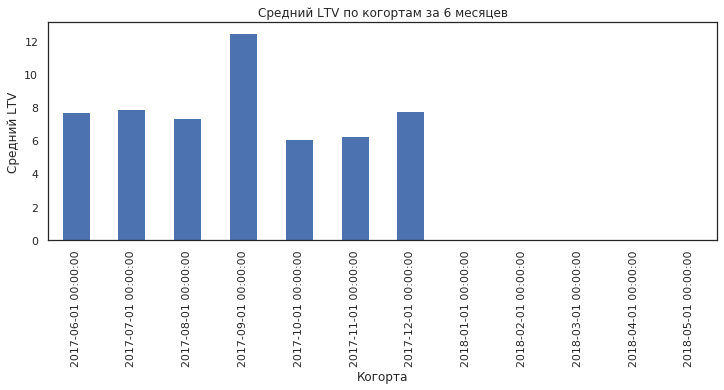

In [87]:
ltv_pivot[5].plot(kind='bar', figsize=(12,4)).set_title('Средний LTV по когортам за 6 месяцев') 
plt.xlabel('Когорта') 
plt.ylabel('Средний LTV'); 
plt.show()

<div class="alert alert-info">
<b>Самые ценные клиенты оказались в сентябрьской когорте, т.к. принесли в среднем со всех своих покупок больше денег</b>
</div>

## Маркетинговые метрики

### Общая сумма расходов на маркетинг

In [88]:
costs.head()

,source_id,costs_ts,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [89]:
costs.groupby(
    ['source_id']
).agg({'costs': 'sum'}).sum()

costs    329131.62
dtype: float64

<div class="alert alert-info">
<b>Суммарные расходы за весь период и по всем источникам - 329 131,62</b>

Ниже рассчитаны расходы по источникам и расходы по источник/месяц.
    
</div>

In [90]:
costs_gr=costs.groupby(
    ['source_id']
).agg({'costs': 'sum'})
costs_gr.sort_values(by = 'costs', ascending = False) 

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


<div class="alert alert-info">
<b>Львиная доля расходов приходится на трафик № 3</b>
</div>

In [91]:
costs_pivot=costs.pivot_table(
    index='source_id',
    columns='month',
    values='costs',
    aggfunc='sum',
) 
costs_pivot

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


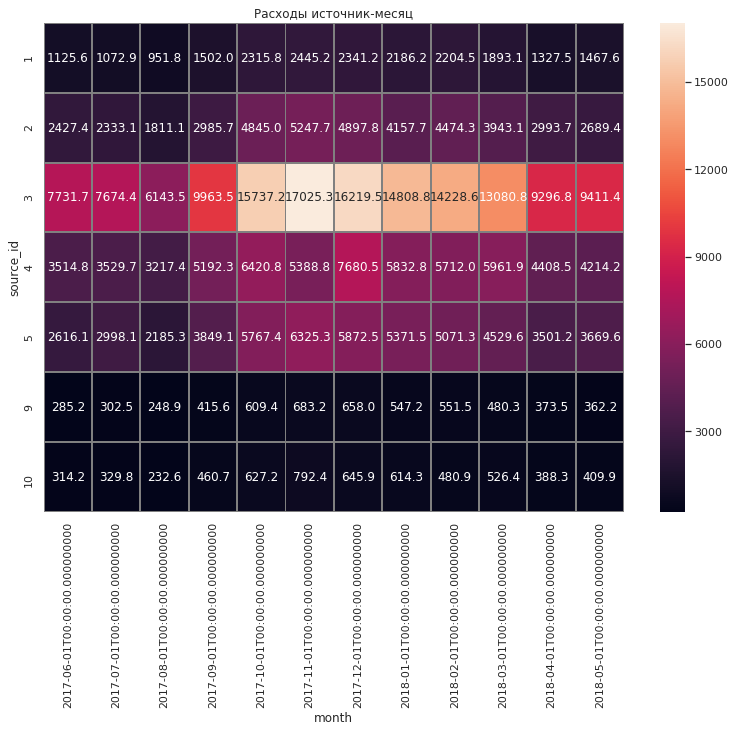

In [92]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Расходы источник-месяц')
sns.heatmap(costs_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray'); 

<div class="alert alert-info">
<b></b>
Расходы увеличиваются осенью-зимой, особенно по 2-5 трафикам.   
</div>

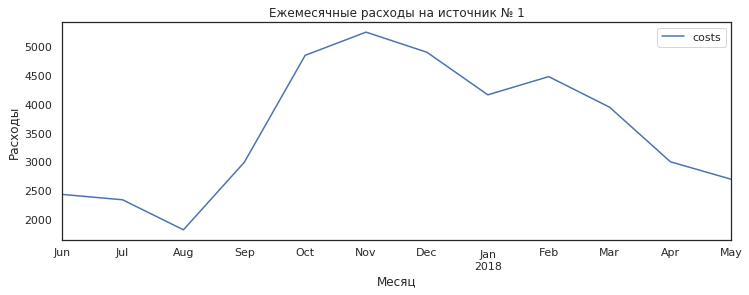

In [93]:
costs.query('source_id ==2').groupby(['month']).agg({'costs': 'sum'}).plot(kind='line', figsize=(12,4)).set_title('Ежемесячные расходы на источник № 1')
plt.xlabel("Месяц") 
plt.ylabel("Расходы");

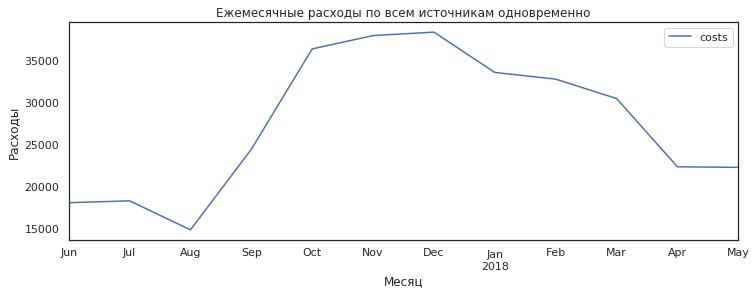

In [94]:
costs.groupby(['month']).agg({'costs': 'sum'}).plot(kind='line', figsize=(12,4)).set_title(
    'Ежемесячные расходы по всем источникам одновременно'
)
plt.xlabel("Месяц") 
plt.ylabel("Расходы");

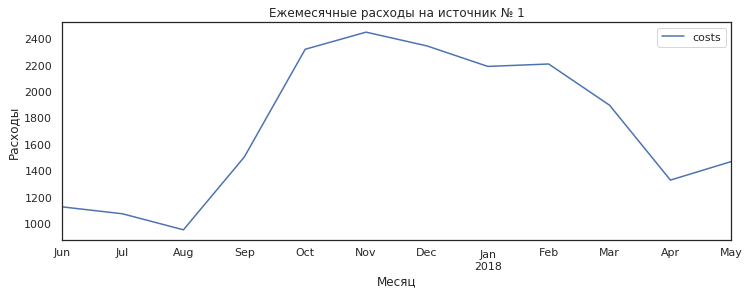

In [95]:
costs.query('source_id == 1').groupby(['month']).agg({'costs': 'sum'}).plot(kind='line', figsize=(12,4)).set_title('Ежемесячные расходы на источник № 1')
plt.xlabel("Месяц") 
plt.ylabel("Расходы");

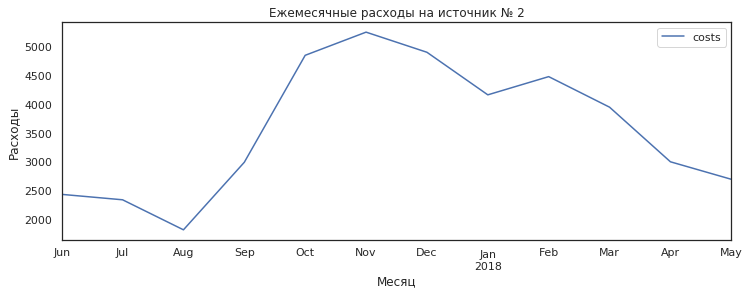

In [96]:
costs.query('source_id ==2').groupby(['month']).agg({'costs': 'sum'}).plot(kind='line', figsize=(12,4)).set_title('Ежемесячные расходы на источник № 2')
plt.xlabel("Месяц") 
plt.ylabel("Расходы");

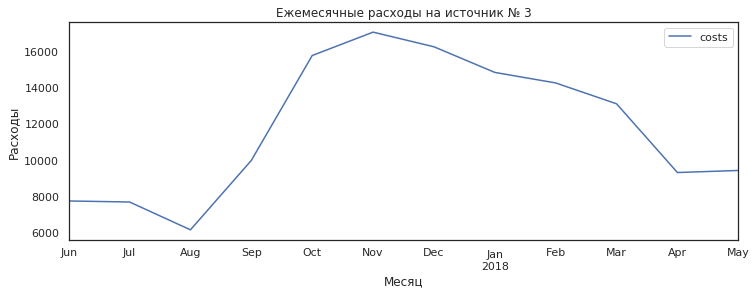

In [97]:
costs.query('source_id ==3').groupby(['month']).agg({'costs': 'sum'}).plot(kind='line', figsize=(12,4)).set_title('Ежемесячные расходы на источник № 3')
plt.xlabel("Месяц") 
plt.ylabel("Расходы");

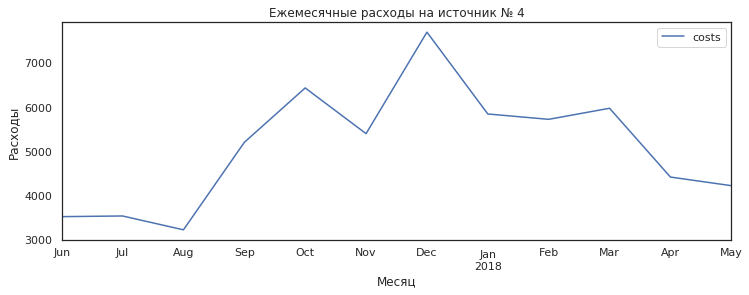

In [98]:
costs.query('source_id ==4').groupby(['month']).agg({'costs': 'sum'}).plot(kind='line', figsize=(12,4)).set_title('Ежемесячные расходы на источник № 4')
plt.xlabel("Месяц") 
plt.ylabel("Расходы");

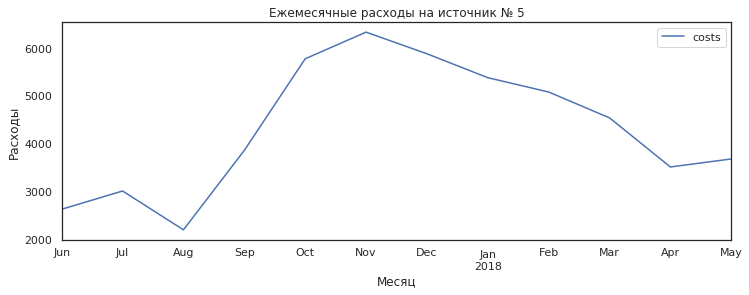

In [99]:
costs.query('source_id ==5').groupby(['month']).agg({'costs': 'sum'}).plot(kind='line', figsize=(12,4)).set_title('Ежемесячные расходы на источник № 5')
plt.xlabel("Месяц") 
plt.ylabel("Расходы");

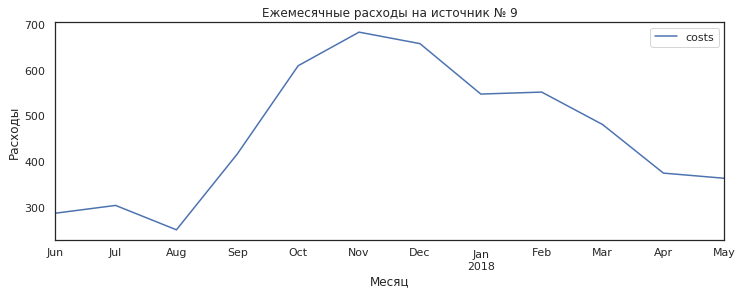

In [100]:
costs.query('source_id ==9').groupby(['month']).agg({'costs': 'sum'}).plot(kind='line', figsize=(12,4)).set_title('Ежемесячные расходы на источник № 9')
plt.xlabel("Месяц") 
plt.ylabel("Расходы");

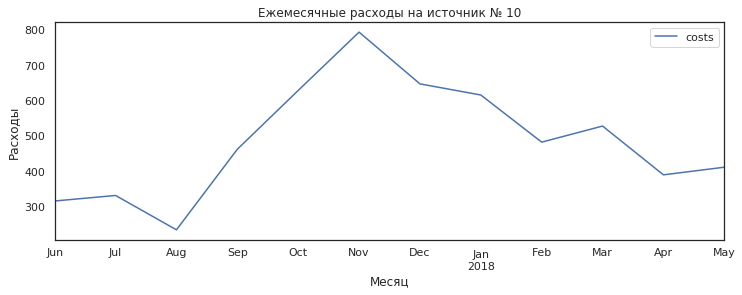

In [101]:
costs.query('source_id ==10').groupby(['month']).agg({'costs': 'sum'}).plot(kind='line', figsize=(12,4)).set_title('Ежемесячные расходы на источник № 10')
plt.xlabel("Месяц") 
plt.ylabel("Расходы");

<div class="alert alert-info">
<b></b>
Расходы по всем источникам увеличиваются осенью, пика достигают в ноябре, далее идет плавное снижение, исключением является 4 трафик, где в ноябре идет снижение и далее резкие подъемы и спады.   
    
Расходы на 4 источник не соответствуют тенденция суммарных расходов.
</div>

### Средний САС на одного покупателя

#### По месяцам

In [102]:
costs.head()

,source_id,costs_ts,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [103]:
costs_month=costs.groupby(
    ['month']
).agg({'costs': 'sum'}).reset_index()
costs_month

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [104]:
orders.head()

,buy_ts,revenue,uid,first_start_order,first_start_visit,visit_order_max,buy_ts_month,first_order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,0,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,0,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,0,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,0,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,0,2017-06-01,2017-06-01,0


In [105]:
orders_month=orders.groupby(
    ['first_order_month']
).agg({'uid': 'nunique'}).reset_index()

orders_month = orders_month.rename(columns=
                   {
                       'first_order_month': 'month',
                       'uid': 'count_uid',
                   }
                  )

orders_month

,month,count_uid
0,2017-06-01,1803
1,2017-07-01,1716
2,2017-08-01,1256
3,2017-09-01,2370
4,2017-10-01,3969
5,2017-11-01,3806
6,2017-12-01,4074
7,2018-01-01,3125
8,2018-02-01,3370
9,2018-03-01,3209


In [106]:
orders_costs_month = pd.merge(costs_month, orders_month, on='month')
orders_costs_month

,month,costs,count_uid
0,2017-06-01,18015.00,1803
1,2017-07-01,18240.59,1716
2,2017-08-01,14790.54,1256
3,2017-09-01,24368.91,2370
4,2017-10-01,36322.88,3969
5,2017-11-01,37907.88,3806
6,2017-12-01,38315.35,4074
7,2018-01-01,33518.52,3125
8,2018-02-01,32723.03,3370
9,2018-03-01,30415.27,3209


In [107]:
orders_costs_month['cost_uid']=orders_costs_month['costs']/orders_costs_month['count_uid']
orders_costs_month

,month,costs,count_uid,cost_uid
0,2017-06-01,18015.00,1803,9.991681
1,2017-07-01,18240.59,1716,10.629714
2,2017-08-01,14790.54,1256,11.775908
3,2017-09-01,24368.91,2370,10.282241
4,2017-10-01,36322.88,3969,9.151645
5,2017-11-01,37907.88,3806,9.960032
6,2017-12-01,38315.35,4074,9.404848
7,2018-01-01,33518.52,3125,10.725926
8,2018-02-01,32723.03,3370,9.710098
9,2018-03-01,30415.27,3209,9.478115


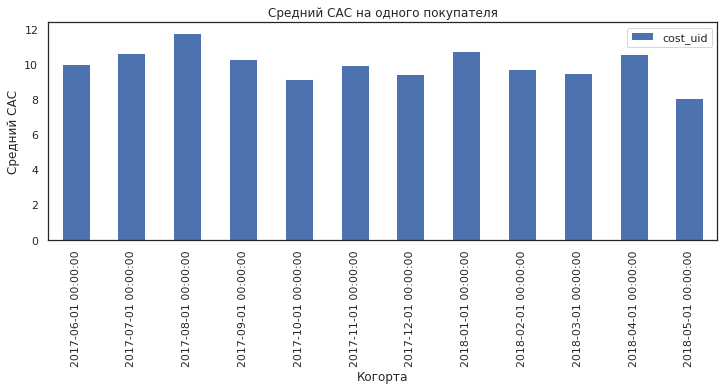

In [108]:
orders_costs_month.groupby(
    ['month']
).agg({'cost_uid': 'sum'}).plot(kind='bar', figsize=(12,4)).set_title('Средний САС на одного покупателя') 
plt.xlabel('Когорта') 
plt.ylabel('Средний САС'); 
plt.show()

<div class="alert alert-info">
<b>Дороже всего обошлись августовские покупатели, а дешевле -майские.</b>
</div>

In [109]:
orders_costs_month.groupby(
    ['month']
).agg({'cost_uid': 'sum'}).mean()

cost_uid    9.977494
dtype: float64

<div class="alert alert-info">
<b>Средний САС = 10.</b>
</div>

#### Месяц-источник

In [110]:
costs_month_source=costs.groupby(
    ['month','source_id']
).agg({'costs': 'sum'}).reset_index()
print(costs_month_source.shape)
costs_month_source

(84, 3)


,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


In [111]:
visit.head()

,device,end_ts,source_id,start_ts,uid,start_month,start_week,start_date,long_dt,first_activity_date,start_date_month,first_date_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,12,51,2017-12-20,00:18:00,2017-12-20,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2,8,2018-02-19,00:28:00,2018-02-19,2018-02-01,2018-02-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,5,20,2018-05-20,00:24:00,2018-03-09,2018-05-01,2018-03-01,2
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,9,35,2017-09-03,00:01:00,2017-09-03,2017-09-01,2017-09-01,0
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,1,5,2018-01-30,00:56:00,2017-06-29,2018-01-01,2017-06-01,7


In [112]:
#выберем только нужные столбцы из таблицы
visit_1=visit[['uid', 'source_id', 'start_ts']]
print(visit_1.shape)
visit_1.head()

(323564, 3)


,uid,source_id,start_ts
0,16879256277535980062,4,2017-12-20 17:20:00
1,104060357244891740,2,2018-02-19 16:53:00
3,16174680259334210214,9,2018-05-20 10:59:00
5,16007536194108375387,5,2017-09-03 21:35:00
6,6661610529277171451,1,2018-01-30 11:13:00


In [113]:
#найдем с какого источника посетитель впервые зашел на сайт
visit_2=visit_1.groupby(
    ['uid']
).agg({'start_ts': 'min'}).reset_index()
print(visit_2.shape)
visit_2.head()

(207022, 2)


,uid,start_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [114]:
#объединим таблицы так, чтобы остались только первоначальные заходы
visit_start= visit_2.merge(visit_1,on=['uid', 'start_ts']) 
print(visit_start.shape)
visit_start.head()

(207022, 3)


,uid,start_ts,source_id
0,11863502262781,2018-03-01 17:27:00,3
1,49537067089222,2018-02-06 15:55:00,2
2,297729379853735,2017-06-07 18:47:00,3
3,313578113262317,2017-09-18 22:49:00,2
4,325320750514679,2017-09-30 14:29:00,5


In [115]:
#выделим месяц первого захода
visit_start['start_date_month']=visit_start['start_ts'].astype('datetime64[M]')
visit_start.head()

,uid,start_ts,source_id,start_date_month
0,11863502262781,2018-03-01 17:27:00,3,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2,2018-02-01
2,297729379853735,2017-06-07 18:47:00,3,2017-06-01
3,313578113262317,2017-09-18 22:49:00,2,2017-09-01
4,325320750514679,2017-09-30 14:29:00,5,2017-09-01


In [116]:
#сгруппируем по месяцу и по источнику, посчитаем кол-во посетителей
visit_month_source=visit_start.groupby(
    ['start_date_month','source_id']
).agg({'uid': 'count'}).reset_index()

visit_month_source = visit_month_source.rename(columns=
                   {
                       'start_date_month': 'month',
                       'uid': 'count_uid',
                   }
                  )
print(visit_month_source.shape)
visit_month_source.head()

(84, 3)


,month,source_id,count_uid
0,2017-06-01,1,599
1,2017-06-01,2,1142
2,2017-06-01,3,3637
3,2017-06-01,4,3081
4,2017-06-01,5,2427


In [117]:
#соединим с расходами
visit_costs_month_source = costs_month_source.merge(visit_month_source,on=['month', 'source_id']) 
print(visit_costs_month_source.shape)
visit_costs_month_source.head()

(84, 4)


,month,source_id,costs,count_uid
0,2017-06-01,1,1125.61,599
1,2017-06-01,2,2427.38,1142
2,2017-06-01,3,7731.65,3637
3,2017-06-01,4,3514.80,3081
4,2017-06-01,5,2616.12,2427


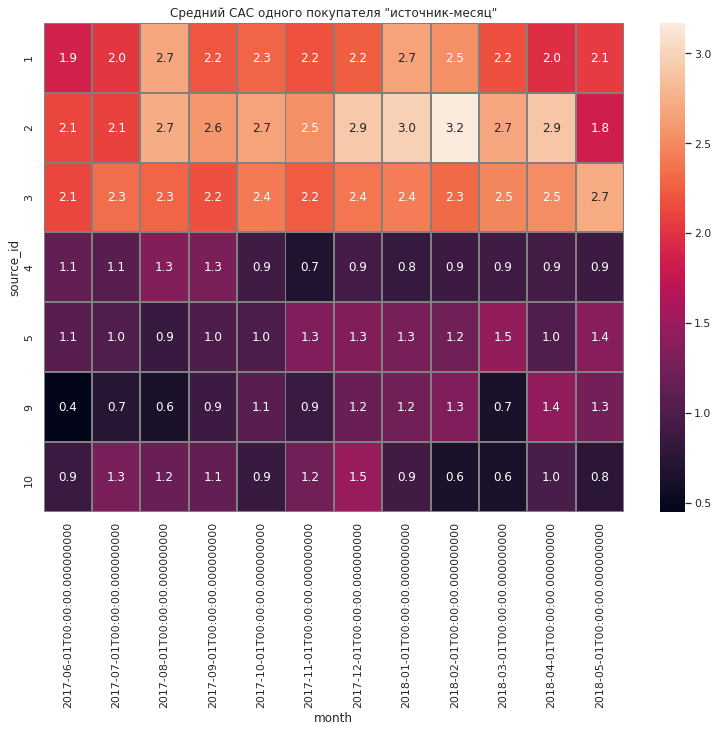

In [118]:
visit_costs_month_source['cost_uid']=visit_costs_month_source['costs']/visit_costs_month_source['count_uid']
visit_costs_month_source_puvot=visit_costs_month_source.pivot_table(
    index='source_id',
    columns='month',
    values='cost_uid',
    aggfunc='sum',
) 

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Средний САС одного покупателя "источник-месяц"')
sns.heatmap(visit_costs_month_source_puvot, annot=True, fmt='.1f', linewidths=1, linecolor='gray'); 

<div class="alert alert-info">
<b>Дороже всего обошлись клиенты, привлеченные через 2 источник в декабре, январе, феврале.</b>
</div>

#### По источникам

In [119]:
visit_costs_month_source.head()

,month,source_id,costs,count_uid,cost_uid
0,2017-06-01,1,1125.61,599,1.879149
1,2017-06-01,2,2427.38,1142,2.125552
2,2017-06-01,3,7731.65,3637,2.125832
3,2017-06-01,4,3514.80,3081,1.140798
4,2017-06-01,5,2616.12,2427,1.077923


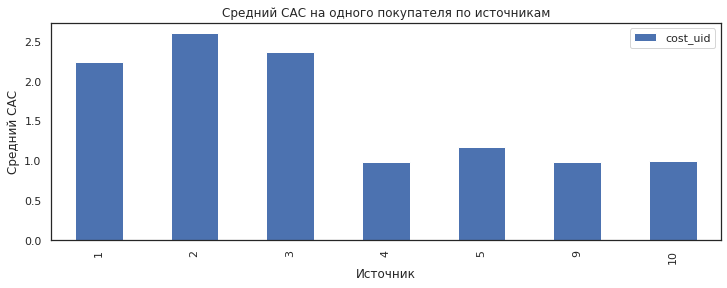

In [120]:
visit_costs_month_source.groupby(
    ['source_id']
).agg({'cost_uid': 'mean'}).plot(kind='bar', figsize=(12,4)).set_title('Средний САС на одного покупателя по источникам') 
plt.xlabel('Источник') 
plt.ylabel('Средний САС'); 
plt.show()


<div class="alert alert-info">
<b>Дороже всего обошлись клиенты привлеченные через 1-3 источники, дешевле - через 4,5,9,10 источники.</b>
</div>

### ROMI

#### Анализ источников

In [121]:
#расходы
print(costs.shape)
costs.head()

(2542, 4)


,source_id,costs_ts,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [122]:
costs_gr=costs.groupby(
    ['source_id']
).agg({'costs': 'sum'}).reset_index()
print(costs_gr.shape)
costs_gr

(7, 2)


,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [123]:
costs_gr_month=costs.groupby(
    ['month']
).agg({'costs': 'sum'}).reset_index()

costs_gr_month

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [124]:
#таблица заказов
print(orders.shape)
orders.head()

(45612, 9)


,buy_ts,revenue,uid,first_start_order,first_start_visit,visit_order_max,buy_ts_month,first_order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01 00:09:00,0,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01 00:14:00,0,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01 00:25:00,0,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01 00:14:00,0,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01 07:31:00,0,2017-06-01,2017-06-01,0


In [125]:
orders_gr=orders.groupby(
    ['first_order_month', 'cohort_lifetime', 'uid']
).agg({'revenue': 'sum'}).reset_index()
print(orders_gr.shape)
orders_gr.head()

(37678, 4)


,first_order_month,cohort_lifetime,uid,revenue
0,2017-06-01,0,16233238570251706,1.65
1,2017-06-01,0,29085576454138824,3.36
2,2017-06-01,0,31782048561502182,6.11
3,2017-06-01,0,50884319066603964,0.98
4,2017-06-01,0,63862661827066303,15.88


In [126]:
#таблица содержит месяц и источник первого захода на сайт
print(visit_start.shape)
visit_start.head()

(207022, 4)


,uid,start_ts,source_id,start_date_month
0,11863502262781,2018-03-01 17:27:00,3,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2,2018-02-01
2,297729379853735,2017-06-07 18:47:00,3,2017-06-01
3,313578113262317,2017-09-18 22:49:00,2,2017-09-01
4,325320750514679,2017-09-30 14:29:00,5,2017-09-01


In [127]:
orders_gr_visit_start = orders_gr.merge(visit_start,on=['uid'])
print(orders_gr_visit_start.shape)
orders_gr_visit_start.head()

(37678, 7)


,first_order_month,cohort_lifetime,uid,revenue,start_ts,source_id,start_date_month
0,2017-06-01,0,16233238570251706,1.65,2017-06-06 20:16:00,3,2017-06-01
1,2017-06-01,0,29085576454138824,3.36,2017-06-08 11:21:00,5,2017-06-01
2,2017-06-01,0,31782048561502182,6.11,2017-06-03 11:12:00,3,2017-06-01
3,2017-06-01,0,50884319066603964,0.98,2017-06-08 13:14:00,3,2017-06-01
4,2017-06-01,0,63862661827066303,15.88,2017-06-14 12:16:00,4,2017-06-01


In [128]:
orders_gr_visit_start['source_id'].value_counts()

3     10700
4     10601
5      6850
2      3862
1      3059
9      1314
10     1292
Name: source_id, dtype: int64

In [129]:
orders_gr_visit_start=orders_gr_visit_start.query('source_id != 7')
orders_gr_visit_start['source_id'].value_counts()

3     10700
4     10601
5      6850
2      3862
1      3059
9      1314
10     1292
Name: source_id, dtype: int64

In [130]:
uid_costs_gr=orders_gr_visit_start.groupby(
    ['source_id']
).agg({'uid': 'nunique'}).reset_index()
uid_costs_gr

,source_id,uid
0,1,2596
1,2,3194
2,3,9688
3,4,9596
4,5,6246
5,9,1028
6,10,1218


In [131]:
uid_costs_merge = uid_costs_gr.merge(costs_gr,on=['source_id'])

uid_costs_merge

,source_id,uid,costs
0,1,2596,20833.27
1,2,3194,42806.04
2,3,9688,141321.63
3,4,9596,61073.60
4,5,6246,51757.10
5,9,1028,5517.49
6,10,1218,5822.49


In [132]:
uid_costs_merge['costs_uid']=uid_costs_merge['costs']/uid_costs_merge['uid']
uid_costs_merge

,source_id,uid,costs,costs_uid
0,1,2596,20833.27,8.025143
1,2,3194,42806.04,13.402016
2,3,9688,141321.63,14.587286
3,4,9596,61073.60,6.364485
4,5,6246,51757.10,8.286439
5,9,1028,5517.49,5.367208
6,10,1218,5822.49,4.780369


In [133]:
def costs_uid(df): #добавим САС клиента
    source_id = df['source_id']
    if source_id == 1:
        return 8.025143
    elif source_id == 2:
        return 13.402016
    elif source_id == 3:
        return 14.587286
    elif source_id == 4:
        return 6.364485
    elif source_id == 5:
        return 8.286439
    elif source_id == 9:
        return 5.367208
    else:
        return 4.780369
    
orders_gr_visit_start['costs_uid'] =  orders_gr_visit_start.apply(costs_uid, axis=1) #новый столбец, функцию ко всей строке

#проверка уникальных значений категории этажей

print(orders_gr_visit_start['costs_uid'].value_counts())

14.587286    10700
6.364485     10601
8.286439      6850
13.402016     3862
8.025143      3059
5.367208      1314
4.780369      1292
Name: costs_uid, dtype: int64


In [134]:
orders_gr_visit_start.head()

,first_order_month,cohort_lifetime,uid,revenue,start_ts,source_id,start_date_month,costs_uid
0,2017-06-01,0,16233238570251706,1.65,2017-06-06 20:16:00,3,2017-06-01,14.587286
1,2017-06-01,0,29085576454138824,3.36,2017-06-08 11:21:00,5,2017-06-01,8.286439
2,2017-06-01,0,31782048561502182,6.11,2017-06-03 11:12:00,3,2017-06-01,14.587286
3,2017-06-01,0,50884319066603964,0.98,2017-06-08 13:14:00,3,2017-06-01,14.587286
4,2017-06-01,0,63862661827066303,15.88,2017-06-14 12:16:00,4,2017-06-01,6.364485


In [135]:
itog=orders_gr_visit_start.groupby(
    ['source_id', 'first_order_month', 'uid']
).agg({'revenue': 'sum', 'costs_uid': 'min'}).reset_index()
itog.head(20)

,source_id,first_order_month,uid,revenue,costs_uid
0,1,2017-06-01,143427074811278640,8.55,8.025143
1,1,2017-06-01,148401564840028266,9.90,8.025143
2,1,2017-06-01,201308712819916034,1.83,8.025143
3,1,2017-06-01,409262394337119652,2.14,8.025143
4,1,2017-06-01,715848749790912625,0.92,8.025143
5,1,2017-06-01,765389942000447725,1.22,8.025143
6,1,2017-06-01,823019665372865584,3.67,8.025143
7,1,2017-06-01,898947171520893840,2.08,8.025143
8,1,2017-06-01,1074355127080856382,0.37,8.025143
9,1,2017-06-01,1150701989604715843,3.30,8.025143


In [136]:
itog_2=itog.groupby(
    ['source_id', 'first_order_month']
).agg({'revenue': 'sum', 'costs_uid': 'sum', 'uid': 'count'}).reset_index()
itog_2.head()

,source_id,first_order_month,revenue,costs_uid,uid
0,1,2017-06-01,3238.29,1243.897165,155
1,1,2017-07-01,3248.71,1139.570306,142
2,1,2017-08-01,2052.01,794.489157,99
3,1,2017-09-01,2419.40,1685.280030,210
4,1,2017-10-01,2548.69,2415.568043,301


In [137]:
itog_2['romi']=(itog_2['revenue']/itog_2['costs_uid'])/itog_2['uid']
itog_2.head()

,source_id,first_order_month,revenue,costs_uid,uid,romi
0,1,2017-06-01,3238.29,1243.897165,155,0.016796
1,1,2017-07-01,3248.71,1139.570306,142,0.020076
2,1,2017-08-01,2052.01,794.489157,99,0.026089
3,1,2017-09-01,2419.40,1685.280030,210,0.006836
4,1,2017-10-01,2548.69,2415.568043,301,0.003505


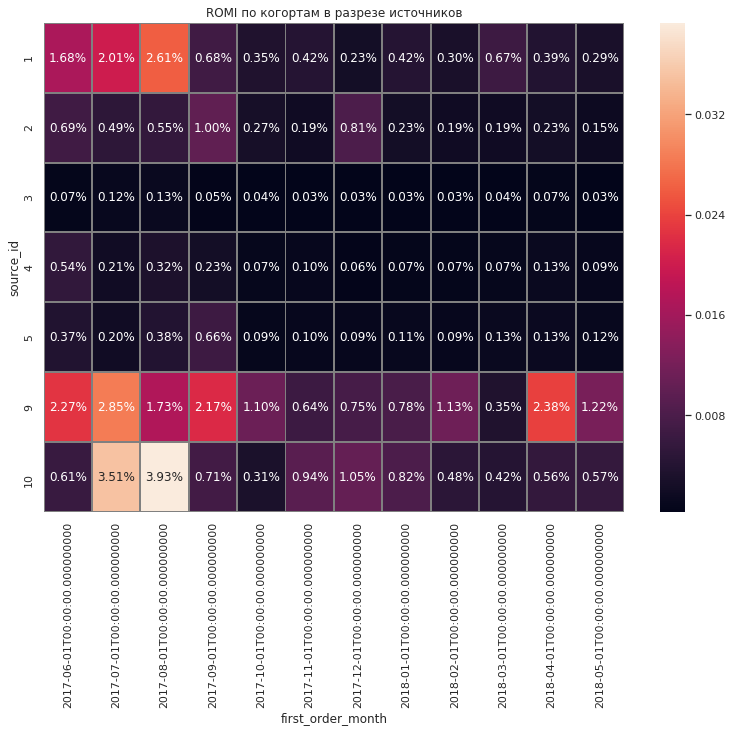

In [138]:
romi=itog_2.pivot_table(
    index='source_id', columns='first_order_month', values='romi', aggfunc='mean'
)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI по когортам в разрезе источников')
sns.heatmap(romi, annot=True, fmt='.2%', linewidths=1, linecolor='gray'); 

<div class="alert alert-info">
<b> </b>
    
    
1.	9 источник окупился и принес прибыль у 8 когорт из 12;
    
    
2. 3,4,5 источники не окупились ни у одной из когорот.
    
    
3. Остальные источники только у нескольких когорт окупились.    
    

</div>

#### Окупаемость

In [139]:
orders_gr_visit_start.head()

,first_order_month,cohort_lifetime,uid,revenue,start_ts,source_id,start_date_month,costs_uid
0,2017-06-01,0,16233238570251706,1.65,2017-06-06 20:16:00,3,2017-06-01,14.587286
1,2017-06-01,0,29085576454138824,3.36,2017-06-08 11:21:00,5,2017-06-01,8.286439
2,2017-06-01,0,31782048561502182,6.11,2017-06-03 11:12:00,3,2017-06-01,14.587286
3,2017-06-01,0,50884319066603964,0.98,2017-06-08 13:14:00,3,2017-06-01,14.587286
4,2017-06-01,0,63862661827066303,15.88,2017-06-14 12:16:00,4,2017-06-01,6.364485


In [140]:
orders_group=orders_gr_visit_start.groupby(
    ['first_order_month', 'cohort_lifetime']
).agg({'revenue': 'sum'}).reset_index()
print(orders_group.shape)
orders_group.head()

(78, 3)


,first_order_month,cohort_lifetime,revenue
0,2017-06-01,0,8419.96
1,2017-06-01,1,813.72
2,2017-06-01,2,752.12
3,2017-06-01,3,1399.98
4,2017-06-01,4,1357.19


In [141]:
costs_gr_month
costs_gr_month = costs_gr_month.rename(columns=
                   {
                       'month': 'first_order_month',
                   }
                  )

In [142]:

costs_gr_month

,first_order_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [143]:
romi_group = orders_group.merge(costs_gr_month,on=['first_order_month'], how='left')
romi_group['costs']=romi_group['costs'].fillna(1)
print(romi_group.shape)
romi_group.head()

(78, 4)


,first_order_month,cohort_lifetime,revenue,costs
0,2017-06-01,0,8419.96,18015.0
1,2017-06-01,1,813.72,18015.0
2,2017-06-01,2,752.12,18015.0
3,2017-06-01,3,1399.98,18015.0
4,2017-06-01,4,1357.19,18015.0


In [144]:
romi_group['romi']=romi_group['revenue']/romi_group['costs']

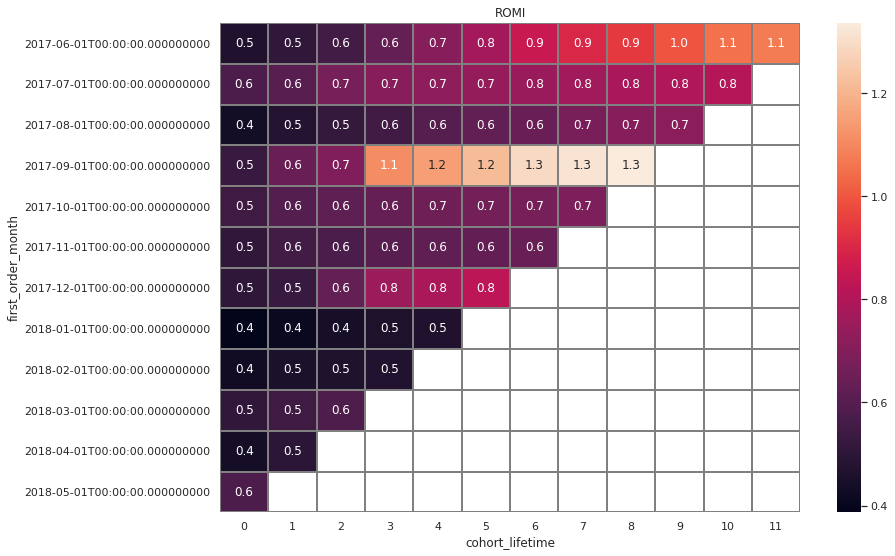

In [145]:
romi_2=romi_group.pivot_table(
    index='first_order_month', columns='cohort_lifetime', values='romi', aggfunc='mean'
)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI')
sns.heatmap(romi_2.cumsum(axis=1), annot=True, fmt='.1f', linewidths=1, linecolor='gray'); 

<div class="alert alert-info">
<b> </b>  

Окупилась июньская когорта к концу девятого месяца и сентябрьская когорта к концу четвертого месяца.
    
Остальные когорты не окупились.
    
    

</div>

## Выводы и рекомендации

<div class="alert alert-info">
<b> </b>
    
**Средний чек** растет у каждой когорты, значит, в целом покупатели становятся лояльнее к продукту. Но возвращается от каждой когорты маленький процент.
    

**Количество уникальных пользователей** в день - 817 человек.
Количество посетителей значительно возрастает 24 ноября, 3090 посетителя за этот день.
Это может быть связано с днем матери, который 25 ноября.
А также есть рост посещений 31 мая, 1825 посетителей за этот день.
Это может быть связано с днем ребенка, который 1 июня.    
    
Если обобщить до месяцев, бОльшая посещаемость в ноябре- декабре и немного меньше февраль-март
Самая низкая посещаемость 30 и 31 марта, и в целом в летние месяцы.

Количество уникальных пользователей в неделю - 5245 человек.
Недельный график посещаемости подтверждает информацию о том, что в середине года, т.е. в летние месяцы значительно меньше заходов.
Конец года (последние 13 недель) и начало года - самые посещаемые.
Количество уникальных пользователей в месяц - 20952 человека.
    
Месячный график наглядно выделяет период с сентября по март включительно, в эти месяцы сервис Афиша наиболее востребован.
    
**% повторного пользования сервисом за год небольшой**    
99,48% посетителей заходят на сайт не более 10 раз за год; 
77.50% - 1 раз за год;      
13.50% - 2 раз за год;          
0,5% пользователей зашли от 10 до 200 раз за год;   
У 22 человек из 201 022 пользователей кол-во сессий за год больше 200.
В среднем пользователи проводят около 11 минут на сайте
Половина пользователей - до 6 минут.
75% пользователей - до 15 минут.

**Максимальный Retention Rate 8,4%.**
Retention Rate по всем когортам снижается.
Привлечённые пользователи пользуется сервисов повторно неохотно, что не очень хорошо для потенциальной выручки.    

Самый маленький **чек** в январе 2018 года, большой - декабрь 2017г.
В июне, сентябре и декабре 2017 пришли самые платежеспособные покупатели.
Средний чек растет у каждой когорты, значит в целом покупатели становятся лояльнее к продукту.
    
Средний чек по всем когортам за весь период - 5.

Средний **LTV** по когортам за 6 месяцев = 7,9
Самые ценные клиенты оказались в сентябрьской когорте, т.к. принесли в среднем со всех своих покупок больше денег.

**Расходы** по всем источникам увеличиваются осенью, пика достигают в ноябре, далее идет плавное снижение, исключением является 4 трафик, где в ноябре идет снижение и далее резкие подъемы и спады.

Расходы на 4 источник не соответствуют тенденция суммарных расходов.

Дороже всего обошлись августовские покупатели, а дешевле -майские.
Средний **САС** = 10.
    
**Источники**   
Дороже всего обошлись клиенты, привлеченные через 2 источник в декабре, январе, феврале.
Дороже всего обошлись клиенты, привлеченные через 1-3 источники, дешевле - через 4,5,9,10 источники.

1.	9 источник окупился и принес прибыль у 8 когорт из 12;
        
2.    3,4,5 источники не окупились ни у одной из когорот.
    
3. Остальные источники только у нескольких когорт окупились.    


**ROMI**
Окупилась июньская когорта к концу девятого месяца и сентябрьская когорта к концу четвертого месяца.
    
Остальные когорты не окупились.
    

</div>


